### Продвинутые методы машинного обучения (1 семестр) 
### Индивидуальное задание по модулю «Визуализация данных»
#### **Выполнил:** Алексеев Арсалан Георгиевич

#### **Датасет №4:** Список персонажей DC Comics
https://www.kaggle.com/datasets/arunasivapragasam/dc-comics

#### Описание:
Мы запускаем свою линейку комиксов и нам нужно определить паттерн (набор черт, например: мужчина с голубыми глазами и с засекреченной личностью, но при этом злодей) пяти наиболее популярных (по числу появлений) персонажей.

#### Гипотеза:
Самые популярные персонажи часто похожи и можно из них выделить некие паттерны, на которые можно опираться при создании персонажей.

![DC comics image](https://assets.nationalnewswatch.com/wp-content/uploads/2013/12/superhero.jpg "DC comics image")

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

# python version 3.9.10

1. Проверим качество данных

In [2]:
# Считываем CSV file в pandas DataFrame
dc = pd.read_csv('data/dc-comics.csv')

# Создадим копию для дальнейшей работы
dc_initially = dc.copy()

In [3]:
# Ознакамливаемся с данными
dc.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,3093.0,"1939, May",1939.0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,2496.0,"1986, October",1986.0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,Living Characters,1565.0,"1959, October",1959.0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,Living Characters,1316.0,"1987, February",1987.0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,1237.0,"1940, April",1940.0


1.a Проверяем типы данных

In [4]:
# Смотрим общую информацию о данных
dc.info()

# Заметим, что только 3 первых столбца не имеют пропусков
# Тип данных столбца FIRST APPEARANCE - object, возможно нужно преобразование
# Остальные типы данных нормальные и в преобразовании не нуждаются

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6896 entries, 0 to 6895
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   page_id           6896 non-null   int64  
 1   name              6896 non-null   object 
 2   urlslug           6896 non-null   object 
 3   ID                4883 non-null   object 
 4   ALIGN             6295 non-null   object 
 5   EYE               3268 non-null   object 
 6   HAIR              4622 non-null   object 
 7   SEX               6771 non-null   object 
 8   ALIVE             6893 non-null   object 
 9   APPEARANCES       6541 non-null   float64
 10  FIRST APPEARANCE  6827 non-null   object 
 11  YEAR              6827 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 646.6+ KB


In [5]:
# Удалим неинформативные стобцы
dc.drop(columns=['page_id', 'urlslug', 'FIRST APPEARANCE'], inplace=True)

# Столбцы 'page_id', 'urlslug' не несут важную для исследования информацию
# Столбец 'FIRST APPEARANCE' дублирует год в столбце YEAR
# Оставим столбец YEAR, так как он уже находится в числовом формате

1.b Проверяем наличие пропусков

In [6]:
display(dc.isnull().tail())
cols_null_percent = dc.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

# Изучим более подробно столбцы с пропусками,
# попытаемся понять с чем связаны пропуски

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
6891,False,False,False,True,True,False,False,True,True
6892,False,False,False,True,True,False,False,True,True
6893,False,False,False,True,True,False,False,True,True
6894,False,False,False,True,True,False,False,True,True
6895,False,False,False,False,False,False,False,True,True


EYE            52.610209
HAIR           32.975638
ID             29.190835
ALIGN           8.715197
APPEARANCES     5.147912
SEX             1.812645
YEAR            1.000580
ALIVE           0.043503
dtype: float64

In [7]:
# Определим столбцы, наличие пропусков в которых может быть обосновано
dc.nunique()
# Наличие пропусках в столбцах APPEARANCES и YEAR явно ошибка

# Список названий характеристик персонажа
dc_characteristics = ['ID', 'ALIGN', 'EYE', 'HAIR', 'SEX', 'ALIVE']

# Посмотрим для каждого столбца уникальные значения

for column in dc[dc_characteristics]:
    dc_cols_unique_values = dc[column].unique()
    print(f"Column: {column}\nUnique Values: {dc_cols_unique_values}\n")

# Наличие пропусков в этих столбцах допустимо и возможно объясняется
# особенностями самого персонажа, а не браком в данных, подробнее разберемся ниже

# Заметим также, что в столбце 'EYE' по ошибке попали значения
# из столбца HAIR: 'Auburn Hair'

Column: ID
Unique Values: ['Secret Identity' 'Public Identity' nan 'Identity Unknown']

Column: ALIGN
Unique Values: ['Good Characters' 'Bad Characters' 'Neutral Characters' nan
 'Reformed Criminals']

Column: EYE
Unique Values: ['Blue Eyes' 'Brown Eyes' 'Green Eyes' 'Purple Eyes' 'Black Eyes'
 'White Eyes' 'Red Eyes' 'Photocellular Eyes' 'Hazel Eyes' 'Amber Eyes'
 'Yellow Eyes' nan 'Grey Eyes' 'Pink Eyes' 'Violet Eyes' 'Gold Eyes'
 'Orange Eyes' 'Auburn Hair']

Column: HAIR
Unique Values: ['Black Hair' 'Brown Hair' 'White Hair' 'Blond Hair' 'Red Hair' nan
 'Green Hair' 'Strawberry Blond Hair' 'Grey Hair' 'Silver Hair'
 'Orange Hair' 'Purple Hair' 'Gold Hair' 'Blue Hair' 'Reddish Brown Hair'
 'Pink Hair' 'Violet Hair' 'Platinum Blond Hair']

Column: SEX
Unique Values: ['Male Characters' 'Female Characters' nan 'Genderless Characters'
 'Transgender Characters']

Column: ALIVE
Unique Values: ['Living Characters' 'Deceased Characters' nan]



In [8]:
# Посмотрим на строки, где произошла ошибка со значениями
dc.loc[dc['EYE'] == 'Auburn Hair']

# Действительно произошла ошибка, в столбце 'HAIR' данные отсутствуют

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
872,Marcia King (New Earth),Public Identity,Good Characters,Auburn Hair,NaN,Female Characters,Living Characters,32.0,1984.0
1776,"Anthony Angelo, Jr. (New Earth)",Public Identity,Neutral Characters,Auburn Hair,NaN,Male Characters,Living Characters,14.0,1989.0
3600,Tawna (New Earth),NaN,Good Characters,Auburn Hair,NaN,Female Characters,Living Characters,5.0,1998.0
3623,Razerkut (New Earth),Secret Identity,Bad Characters,Auburn Hair,NaN,Female Characters,Living Characters,5.0,1995.0
3627,Carla Draper (New Earth),Public Identity,Bad Characters,Auburn Hair,NaN,Female Characters,Living Characters,5.0,1994.0
4070,Madolyn Corbett (New Earth),NaN,Neutral Characters,Auburn Hair,NaN,Female Characters,Deceased Characters,4.0,1995.0
5346,Sally Milton (New Earth),Public Identity,NaN,Auburn Hair,NaN,Female Characters,Living Characters,2.0,1988.0


In [9]:
# Временно запомним номера ошибочных строк
dc_index_tp = dc[dc['EYE'] == 'Auburn Hair'].index

# Заменим ошибочные ячейки на пропуски
dc.loc[dc_index_tp, ['EYE']] = np.nan
dc.loc[dc_index_tp, ['HAIR']] = 'Auburn Hair'

# Проверим результат замены
dc.loc[dc_index_tp]

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
872,Marcia King (New Earth),Public Identity,Good Characters,NaN,Auburn Hair,Female Characters,Living Characters,32.0,1984.0
1776,"Anthony Angelo, Jr. (New Earth)",Public Identity,Neutral Characters,NaN,Auburn Hair,Male Characters,Living Characters,14.0,1989.0
3600,Tawna (New Earth),NaN,Good Characters,NaN,Auburn Hair,Female Characters,Living Characters,5.0,1998.0
3623,Razerkut (New Earth),Secret Identity,Bad Characters,NaN,Auburn Hair,Female Characters,Living Characters,5.0,1995.0
3627,Carla Draper (New Earth),Public Identity,Bad Characters,NaN,Auburn Hair,Female Characters,Living Characters,5.0,1994.0
4070,Madolyn Corbett (New Earth),NaN,Neutral Characters,NaN,Auburn Hair,Female Characters,Deceased Characters,4.0,1995.0
5346,Sally Milton (New Earth),Public Identity,NaN,NaN,Auburn Hair,Female Characters,Living Characters,2.0,1988.0


Так как столбец EYE имеет большое количество пропусков (более 50%) разберемся,
с чем связаны пропуски и насколько критично удаление строк с пропусками.

Как мы видим ниже, у персонажа Susan Dearbon (New Earth) в строке EYE: NaN, но согласно Wiki, данный персонаж и правда ослеп, отбрасывать подобные пропуски мы не будем. Но для сравнения Samuel Morgan (New Earth) имеет пропуск в столбце EYE,
возможно обусловленный старым стилем рисовки (глаза обазначены просто точкой).

In [10]:
cols_null_percent = dc.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)

# посмотрим начиная с какого персонажа возникают пропуски
display(dc.loc[dc['EYE'].isnull()].head())

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
95,Susan Dearbon (New Earth),Public Identity,Good Characters,NaN,Black Hair,Female Characters,Deceased Characters,235.0,1961.0
118,James Ewell Brown Stuart (New Earth),Public Identity,Good Characters,NaN,Brown Hair,Male Characters,Deceased Characters,212.0,1961.0
122,Wolfgang Winks (New Earth),Public Identity,Good Characters,NaN,Black Hair,Male Characters,Living Characters,206.0,1942.0
164,Andre Chavard (New Earth),Public Identity,Good Characters,NaN,Brown Hair,Male Characters,Living Characters,164.0,1942.0
181,Samuel Morgan (New Earth),NaN,Good Characters,NaN,Red Hair,Male Characters,Deceased Characters,155.0,1937.0


Узнаем какой максимальный год для пропусков в столбце 'EYE'

In [11]:
# Отсортируем данные, узнаем какой максимальный год, когда есть пропуски в EYE
dc[dc['EYE'].isnull()].sort_values(by=['YEAR'], ascending=False)

# 2013 год говорит о том, что в данных ошибка, цветные глаза явно появились раньше

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
5539,Springheeled Jack (Prime Earth),Secret Identity,Bad Characters,NaN,NaN,Male Characters,Living Characters,1.0,2013.0
5540,Napalm (Prime Earth),Secret Identity,Bad Characters,NaN,NaN,Male Characters,Deceased Characters,1.0,2012.0
4324,Ragnar (Green Lantern Animated Series),Public Identity,Bad Characters,NaN,NaN,Male Characters,Living Characters,3.0,2012.0
6541,Matteo Bischoff (New Earth),Secret Identity,Bad Characters,NaN,Grey Hair,Male Characters,Living Characters,NaN,2012.0
5578,Mister Unknown (New Earth),Secret Identity,Good Characters,NaN,Black Hair,Male Characters,Deceased Characters,1.0,2011.0
...,...,...,...,...,...,...,...,...,...
6890,James Garfield (New Earth),Public Identity,Good Characters,NaN,NaN,Male Characters,Living Characters,NaN,NaN
6891,Nadine West (New Earth),Public Identity,Good Characters,NaN,NaN,Female Characters,Living Characters,NaN,NaN
6892,Warren Harding (New Earth),Public Identity,Good Characters,NaN,NaN,Male Characters,Living Characters,NaN,NaN
6893,William Harrison (New Earth),Public Identity,Good Characters,NaN,NaN,Male Characters,Living Characters,NaN,NaN


Узнаем с какого года начинается цветная рисовка глаз

In [12]:
# Отсортируем данные, узнаем какой минимальные год, когда нет пропусков в EYE
dc[dc['EYE'].notnull()].sort_values(by=['YEAR'], ascending=True)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
231,Richard Occult (New Earth),Secret Identity,NaN,Grey Eyes,Black Hair,Male Characters,Living Characters,125.0,1935.0
705,Arthur Pendragon (New Earth),Public Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,Living Characters,41.0,1936.0
1936,Lady of the Lake (New Earth),NaN,Good Characters,Blue Eyes,Blue Hair,Female Characters,Living Characters,13.0,1936.0
321,Merlin (New Earth),Secret Identity,Neutral Characters,Black Eyes,White Hair,Male Characters,Living Characters,92.0,1936.0
385,Cyril Saunders (New Earth),Public Identity,Good Characters,Hazel Eyes,White Hair,Male Characters,Living Characters,79.0,1937.0
...,...,...,...,...,...,...,...,...,...
6533,"Frank Baker, Jr. (New Earth)",Public Identity,Neutral Characters,Blue Eyes,Grey Hair,Male Characters,Living Characters,1.0,NaN
6534,Prowley (New Earth),Public Identity,Neutral Characters,Yellow Eyes,Black Hair,NaN,Living Characters,1.0,NaN
6536,Mark Antaeus (New Earth),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Deceased Characters,1.0,NaN
6539,Ben Lo (New Earth),Public Identity,Good Characters,Brown Eyes,Black Hair,Male Characters,Living Characters,1.0,NaN


в 1935 у других персонажей уже были цветные глаза, либо описание цвета их глаз добавили позже,
ибо в те года, не всем персонажам давали цветные глаза, или ошибка.
Гипотеза про точечную рисовку глаз не подтвердилась.

In [13]:
# общее количество появлений персонажей с отсутствующими данными в столбце 'EYE'
dc_eye_nan = dc.loc[dc['EYE'].isnull()]['APPEARANCES'].sum()

# процент появления персонажей с отсутствующими данными в столбце 'EYE' от общего суммы появлений 
dc_eye_nan_perc = 100 * dc_eye_nan/dc['APPEARANCES'].sum()

print(f'процент появления персонажей с отсутствующими данными в столбце EYE: {round(dc_eye_nan_perc,2)}')

процент появления персонажей с отсутствующими данными в столбце EYE: 17.37


В итоге, удаление пропусков из столбца 'EYE', приведет к потере большого количества строк, но данный столбец явно содержит пропуски, возможно связанные с особенностями персонажей, нехваткой данных или небрежностью к второстепенным персонажам. Согласно Wiki дефект глаз имеет более 100 персонажей. Совокупно строки с пропусками в столбце EYE имеют 17% от суммарного появления персонажей и изначально составляли более 50% от всех строк в столбце. Заменим пропуски на Unknown.

Рассмотрим другие столбцы с пропусками

In [14]:
display(dc.loc[dc['ID'].isnull()].head())

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
181,Samuel Morgan (New Earth),NaN,Good Characters,NaN,Red Hair,Male Characters,Deceased Characters,155.0,1937.0
203,Tubby Watts (New Earth),NaN,Good Characters,NaN,Red Hair,Male Characters,Living Characters,137.0,1941.0
220,Victory (New Earth),NaN,Good Characters,Black Eyes,White Hair,Male Characters,Living Characters,130.0,1941.0
251,Dolphin (New Earth),NaN,Good Characters,Blue Eyes,Silver Hair,Female Characters,Deceased Characters,115.0,1968.0
277,Sugar Plumm (New Earth),NaN,Good Characters,NaN,Blond Hair,Female Characters,Living Characters,105.0,1956.0


Пропуски в столбце ID в основном связаны с тем, что в описании не всех персонажей есть информации о том, какая личность скрытая или общественная. Учитывая, что в этом столбце есть также вариант Identity Unknown, то заменим пропуски на это.

In [15]:
display(dc.loc[dc['ALIGN'].isnull()].head())

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
22,Ted Grant (New Earth),Secret Identity,NaN,Blue Eyes,Black Hair,Male Characters,Living Characters,605.0,1942.0
27,Ralph Dibny (New Earth),Public Identity,NaN,Blue Eyes,Red Hair,Male Characters,Deceased Characters,558.0,1960.0
33,Rex Mason (New Earth),Secret Identity,NaN,Black Eyes,NaN,Male Characters,Living Characters,470.0,1965.0
35,Aztar (New Earth),Secret Identity,NaN,White Eyes,NaN,Male Characters,Living Characters,436.0,1940.0
36,Theodore Kord (New Earth),Secret Identity,NaN,Blue Eyes,Brown Hair,Male Characters,Deceased Characters,429.0,1986.0


Пропуски в данном столбце ALIGN скорее всего несут ошибку, 
ввиду того определить добрый или злой персонаж не является затруднительным.
Согласно wiki для большинства персонажей данный параметр определен,
однако персонажи имеющие пропуски в столбце ALIGN, достаточно популярны и нельзя точно определить как трактовать пропуски, как добрых или злых персонажей, при этом исправившиеся преступники, также были как злыми, так и добрыми. Для дальнейшего анализа обозначим их как Нейтральных, для соблюдения баланса в данных.

In [16]:
display(dc.loc[dc['HAIR'].isnull()].head())

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
18,Raymond Palmer (New Earth),Public Identity,Good Characters,Brown Eyes,NaN,Male Characters,Living Characters,706.0,1961.0
19,Alexander Luthor (New Earth),Public Identity,Bad Characters,Green Eyes,NaN,Male Characters,Living Characters,677.0,1986.0
31,Franklin Rock (New Earth),Public Identity,Good Characters,Blue Eyes,NaN,Male Characters,Living Characters,492.0,1959.0
33,Rex Mason (New Earth),Secret Identity,NaN,Black Eyes,NaN,Male Characters,Living Characters,470.0,1965.0
35,Aztar (New Earth),Secret Identity,NaN,White Eyes,NaN,Male Characters,Living Characters,436.0,1940.0


пропуски в данной графе HAIR скорее всего связаны с тем, что персонаж либо лысый, 
либо не снимает головной убор/костюм, либо не имеет волос изначально

In [17]:
display(dc.loc[dc['SEX'].isnull()].head())

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
242,Khaji Da (New Earth),Secret Identity,Good Characters,NaN,NaN,NaN,Living Characters,121.0,1964.0
343,Rosabelle Mendez (New Earth),Secret Identity,Good Characters,Red Eyes,NaN,NaN,Deceased Characters,86.0,1991.0
352,Parallax (New Earth),Secret Identity,Bad Characters,NaN,NaN,NaN,Living Characters,84.0,1994.0
514,Chemo (New Earth),Public Identity,Bad Characters,NaN,NaN,NaN,Living Characters,58.0,1962.0
628,Ion (New Earth),Secret Identity,Good Characters,Green Eyes,NaN,NaN,Deceased Characters,45.0,2006.0


В столбце SEX, уже есть позиция Genderless Characters, для бесполых или тех персонажей, чей пол невозможно определить, поэтому отсутствие данных в этом столбце - ошибка. 

Также заметим, персонажи не имеющие параматеров EYE, HAIR, SEX представляют из себя не человека, 
а какую-то другую форму жизни, поэтому это не является ошибкой, но такие персонажи не представляют ценность,
поэтому удалим строки содержащие от 3 пропусков.

In [18]:
display(dc.loc[dc['ALIVE'].isnull()].head())

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
2726,Hatshephut II (New Earth),Public Identity,Bad Characters,NaN,NaN,Female Characters,NaN,8.0,1992.0
3250,Leander (New Earth),Public Identity,Good Characters,NaN,Blue Hair,Male Characters,NaN,6.0,1997.0
6854,Mrblonde267\/Buddy Blank (New Earth),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1974.0


Персонажей чья судьба неизвестна не так много, поэтому пропуски в столбце ALIVE, будем считать ошибкой, удаляя пропуски и предполагать, что персонаж по умолчанию либо мертв, либо жив.

Резюмируем, наши действия относительно пропусков.

* EYE            (52.61% пропусков)  __Заменяем на Unknown__
* HAIR           (32.97% пропусков)  __Заменяем на Unknown__
* ID             (29.19% пропусков)  __Объединяем с Identity Unknown__
* ALIGN           (8.71% пропусков)  __Объединяем пропуски, Reformed Criminals, Neutral Characters__
* APPEARANCES     (5.14% пропусков)  __Удаляем пропуски__
* SEX             (1.81% пропусков)  __Удаляем пропуски__
* YEAR            (1.00% пропусков)  __Удаляем пропуски__
* ALIVE           (0.04% пропусков)  __Удаляем пропуски__

Сначала удалим строки с пропусками в столбцах:
APPEARANCES, SEX, YEAR, ALIVE

In [19]:
# Удалим строки содержащие пропуски в столбцах 'APPEARANCES', 'SEX', 'YEAR', 'ALIVE'
# Наличие пропусков в этих столбцах является ошибкой
dc.dropna(subset=['APPEARANCES','SEX', 'YEAR', 'ALIVE'], inplace=True)

#выводим долю пропусков после преобразования
print(f'Результирующее число строк ДО: {dc_initially.shape[0]}')
print(f'Результирующее число строк ПОСЛЕ: {dc.shape[0]}')
display(dc.isnull().mean())

Результирующее число строк ДО: 6896
Результирующее число строк ПОСЛЕ: 6366


name           0.000000
ID             0.281810
ALIGN          0.083883
EYE            0.517279
HAIR           0.308043
SEX            0.000000
ALIVE          0.000000
APPEARANCES    0.000000
YEAR           0.000000
dtype: float64

Теперь отбрасываем строки с числом пропусков от 2 и более, так как данные строки заполнены неверно или неинформативно.
Строки, содержащие 1 пропуск скорее всего имеют его, в виду особенностей персонажа, на паре примеров мы это проверили. Безусловно, были персонажи, которые имели 2 пропуска из-за особенностей персонажа, но большая часть строк с 2 пропусками - это ошибки.

In [20]:
m = dc.shape[1] #число столбцов
dc = dc.dropna(axis=0,thresh=m-2)

#выводим долю пропусков после преобразования
print(f'Результирующее число строк ДО: {dc_initially.shape[0]}')
print(f'Результирующее число строк ПОСЛЕ: {dc.shape[0]}')
display(dc.isnull().mean())

Результирующее число строк ДО: 6896
Результирующее число строк ПОСЛЕ: 5519


name           0.000000
ID             0.182461
ALIGN          0.054176
EYE            0.443377
HAIR           0.217431
SEX            0.000000
ALIVE          0.000000
APPEARANCES    0.000000
YEAR           0.000000
dtype: float64

Объединяем и заменяем пропуски в столбцах:

* Столбец ID

In [21]:
# Заменим оставшиеся пропуски на 'Unknown'
dc['ID'].fillna('Unknown', inplace=True)

# В столбце ID есть строки Identity Unknown, заменим их также на Unknown
dc['ID'] = dc['ID'].replace('Identity Unknown', 'Unknown')

#выводим долю пропусков после преобразования
print(f'Результирующее число строк ДО: {dc_initially.shape[0]}')
print(f'Результирующее число строк ПОСЛЕ: {dc.shape[0]}')
display(dc.isnull().mean())

Результирующее число строк ДО: 6896
Результирующее число строк ПОСЛЕ: 5519


name           0.000000
ID             0.000000
ALIGN          0.054176
EYE            0.443377
HAIR           0.217431
SEX            0.000000
ALIVE          0.000000
APPEARANCES    0.000000
YEAR           0.000000
dtype: float64

* Столбец ALIGN

In [22]:
# Заменим оставшиеся пропуски на 'Unknown'
dc['ALIGN'].fillna('Neutral Characters', inplace=True)

# В столбце ID есть строки Identity Unknown, заменим их также на Unknown
dc['ALIGN'] = dc['ALIGN'].replace('Reformed Criminals', 'Neutral Characters')

#выводим долю пропусков после преобразования
print(f'Результирующее число строк ДО: {dc_initially.shape[0]}')
print(f'Результирующее число строк ПОСЛЕ: {dc.shape[0]}')
display(dc.isnull().mean())

Результирующее число строк ДО: 6896
Результирующее число строк ПОСЛЕ: 5519


name           0.000000
ID             0.000000
ALIGN          0.000000
EYE            0.443377
HAIR           0.217431
SEX            0.000000
ALIVE          0.000000
APPEARANCES    0.000000
YEAR           0.000000
dtype: float64

* Столбец HAIR

In [23]:
# Заменим оставшиеся пропуски на 'Unknown'
dc['HAIR'].fillna('Unknown', inplace=True)

#выводим долю пропусков после преобразования
print(f'Результирующее число строк ДО: {dc_initially.shape[0]}')
print(f'Результирующее число строк ПОСЛЕ: {dc.shape[0]}')
display(dc.isnull().mean())

Результирующее число строк ДО: 6896
Результирующее число строк ПОСЛЕ: 5519


name           0.000000
ID             0.000000
ALIGN          0.000000
EYE            0.443377
HAIR           0.000000
SEX            0.000000
ALIVE          0.000000
APPEARANCES    0.000000
YEAR           0.000000
dtype: float64

* Столбец EYE

In [24]:
# Заменим оставшиеся пропуски на 'Unknown'
dc['EYE'].fillna('Unknown', inplace=True)

#выводим долю пропусков после преобразования
print(f'Результирующее число строк ДО: {dc_initially.shape[0]}')
print(f'Результирующее число строк ПОСЛЕ: {dc.shape[0]}')
display(dc.isnull().mean())

Результирующее число строк ДО: 6896
Результирующее число строк ПОСЛЕ: 5519


name           0.0
ID             0.0
ALIGN          0.0
EYE            0.0
HAIR           0.0
SEX            0.0
ALIVE          0.0
APPEARANCES    0.0
YEAR           0.0
dtype: float64

1.c Проверяем наличие дубликатов

In [25]:
dupl_columns = list(dc.columns)
mask = dc.duplicated(subset=dupl_columns)
dc_duplicates = dc[mask]
print(f'Число найденных дубликатов: {dc_duplicates.shape[0]}')
dc = dc.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {dc.shape[0]}')

# Дубликатов не обнаружено

Число найденных дубликатов: 0
Результирующее число записей: 5519


2.Рассчитаем основные показатели

Посмотрим основные статистические показатели для числовых переменных, такие как среднее, медиана, стандартное отклонение, минимум, максимум, квантили

In [26]:
dc.describe()

,APPEARANCES,YEAR
count,5519.000000,5519.000000
mean,26.927523,1989.492299
std,94.671297,17.109509
min,1.000000,1935.000000
25%,3.000000,1983.000000
50%,7.000000,1992.000000
75%,18.000000,2003.000000
max,3093.000000,2013.000000


Из таблицы можно подметить следующее:
* в среднем персонажи появляются 27 раз (+/- 95 раз)
* большое количество персонажей появилось в период с 1972 по 2006 гг.
* медианы для частоты появления - 7, для года - 1992
* данные представлены с 1935 по 2013 гг

Посмотрим основные статистические показатели для категориальных переменных, такие как
* общее количество значений (count)
* количество уникальных значений (unique)
* наиболее часто встречающееся значение (top)
* и количество таких значений (freq)

In [27]:
dc.describe(include='object')

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE
count,5519,5519,5519,5519,5519,5519,5519
unique,5519,3,3,17,19,3,2
top,Batman (Bruce Wayne),Public Identity,Good Characters,Unknown,Black Hair,Male Characters,Living Characters
freq,1,2299,2454,2447,1470,3821,4109


Из таблицы можно подметить следующее:
* самый популярный персонаж - Batman (Bruce Wayne)
* большое количество персонажей с неизвестным цветом глаз осталось после работы с пропусками
* чаще встречаются мужские персонажи
* чаще встречаются публичные личности
* чаще встречаются добрые персонажи
* чаще встречаются персонажи с черными волосами

Узнаем какой тип пола удалился из столбца SEX после пропусков и в каком количестве, возможно произошла потеря важных данных

In [28]:
# Посмотрим для каждого столбца уникальные значения

for column in dc[dc_characteristics]:
    dc_cols_unique_values = dc[column].unique()
    print(f"Column: {column}\nUnique Values: {dc_cols_unique_values}\n")

Column: ID
Unique Values: ['Secret Identity' 'Public Identity' 'Unknown']

Column: ALIGN
Unique Values: ['Good Characters' 'Bad Characters' 'Neutral Characters']

Column: EYE
Unique Values: ['Blue Eyes' 'Brown Eyes' 'Green Eyes' 'Purple Eyes' 'Black Eyes'
 'White Eyes' 'Red Eyes' 'Photocellular Eyes' 'Hazel Eyes' 'Amber Eyes'
 'Yellow Eyes' 'Unknown' 'Grey Eyes' 'Pink Eyes' 'Violet Eyes' 'Gold Eyes'
 'Orange Eyes']

Column: HAIR
Unique Values: ['Black Hair' 'Brown Hair' 'White Hair' 'Blond Hair' 'Red Hair' 'Unknown'
 'Green Hair' 'Strawberry Blond Hair' 'Grey Hair' 'Silver Hair'
 'Orange Hair' 'Purple Hair' 'Gold Hair' 'Blue Hair' 'Reddish Brown Hair'
 'Pink Hair' 'Auburn Hair' 'Violet Hair' 'Platinum Blond Hair']

Column: SEX
Unique Values: ['Male Characters' 'Female Characters' 'Genderless Characters']

Column: ALIVE
Unique Values: ['Living Characters' 'Deceased Characters']



В ходе работы с пропусками удалился тип пола Transgender Characters, узнаем в каком количестве была представлена изначально эта категория.

In [29]:
display(dc_initially.loc[dc_initially['SEX'] == 'Transgender Characters'])

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
3877,317067,Daystar (New Earth),\/wiki\/Daystar_(New_Earth),NaN,Bad Characters,NaN,NaN,Transgender Characters,Deceased Characters,4.0,"2009, October",2009.0


Как видим, всего одна строка удалилась, при этом важных данных в ней и не было.

Посмотрим другие статистические показатели.

In [30]:
%%%%

UsageError: Cell magic `%%%%` not found.


Выведим другие важные показатели:
(популярность определяется по числу появлений в комиксах DC)

In [31]:
# Определим 5 самых популярных персонажей
dc_pop_top5 = dc.sort_values('APPEARANCES', ascending=False, ignore_index=True).head()

# Отдельно сохраним характеристики 5 самых популярных персонажей
dc_pop_place1 = list(dc_pop_top5.loc[0,dc_characteristics])
dc_pop_place2 = list(dc_pop_top5.loc[1,dc_characteristics])
dc_pop_place3 = list(dc_pop_top5.loc[2,dc_characteristics])
dc_pop_place4 = list(dc_pop_top5.loc[3,dc_characteristics])
dc_pop_place5 = list(dc_pop_top5.loc[4,dc_characteristics])

display(dc_pop_top5)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,Batman (Bruce Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,3093.0,1939.0
1,Superman (Clark Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,2496.0,1986.0
2,Green Lantern (Hal Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,Living Characters,1565.0,1959.0
3,James Gordon (New Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,Living Characters,1316.0,1987.0
4,Richard Grayson (New Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,1237.0,1940.0


Для дальнейшего сохранения списка характеристик топ5 персонажей, воспользуемся функцией

In [32]:

# сохраниним список характеристик 5 персонажей в отдельный список
def list_top(top):
    x = [list(top.loc[i,dc_characteristics]) for i in range(5)]
    return x

# Проверим правильность работы функции
print(list_top(dc_pop_top5)[0] == dc_pop_place1)


True


In [33]:
# Определим 5 самых популярных новых персонажей, появившихся за последние 2 года (2012-2013)
mask1 = dc['YEAR'] > 2011

dc_pop_new_top5 = dc[mask1].sort_values(
    by='APPEARANCES',
    ascending= False,
    ignore_index=True
).head()

display(dc_pop_new_top5)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,Kimberly Rebecki (Prime Earth),Public Identity,Neutral Characters,Brown Eyes,Brown Hair,Female Characters,Living Characters,7.0,2012.0
1,Rachel Niamo (Prime Earth),Secret Identity,Neutral Characters,Brown Eyes,Brown Hair,Female Characters,Living Characters,6.0,2012.0
2,Ragnar (Green Lantern Animated Series),Public Identity,Bad Characters,Unknown,Unknown,Male Characters,Living Characters,3.0,2012.0
3,Springheeled Jack (Prime Earth),Secret Identity,Bad Characters,Unknown,Unknown,Male Characters,Living Characters,1.0,2013.0
4,Napalm (Prime Earth),Secret Identity,Bad Characters,Unknown,Unknown,Male Characters,Deceased Characters,1.0,2012.0


In [34]:
# Определим 5 самых популярных добрых персонажей
mask1 = dc['ALIGN'] == 'Good Characters'

dc_good_top5 = dc[mask1].sort_values(
    by='APPEARANCES',
    ascending= False,
    ignore_index=True
).head()

display(dc_good_top5)
# Заметим, что список совпал с 5 самыми популярными персонажами

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,Batman (Bruce Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,3093.0,1939.0
1,Superman (Clark Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,2496.0,1986.0
2,Green Lantern (Hal Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,Living Characters,1565.0,1959.0
3,James Gordon (New Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,Living Characters,1316.0,1987.0
4,Richard Grayson (New Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,1237.0,1940.0


In [35]:
# Определим 5 самых популярных злых персонажей
mask1 = dc['ALIGN'] == 'Bad Characters'

dc_bad_top5 = dc[mask1].sort_values(
    by='APPEARANCES',
    ascending= False,
    ignore_index=True
).head()

display(dc_bad_top5)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,Alexander Luthor (New Earth),Public Identity,Bad Characters,Green Eyes,Unknown,Male Characters,Living Characters,677.0,1986.0
1,Joker (New Earth),Secret Identity,Bad Characters,Green Eyes,Green Hair,Male Characters,Living Characters,517.0,1940.0
2,Uxas (New Earth),Public Identity,Bad Characters,Red Eyes,Unknown,Male Characters,Deceased Characters,388.0,1970.0
3,Harvey Dent (New Earth),Public Identity,Bad Characters,Blue Eyes,Brown Hair,Male Characters,Living Characters,306.0,1942.0
4,Jonathan Crane (New Earth),Public Identity,Bad Characters,Blue Eyes,Brown Hair,Male Characters,Living Characters,222.0,1941.0


In [36]:
# Определим 5 самых популярных мужских персонажей
mask1 = dc['SEX'] == 'Male Characters'

dc_male_top5 = dc[mask1].sort_values(
    by='APPEARANCES',
    ascending= False,
    ignore_index=True
).head()

display(dc_male_top5)

# Заметим, что список совпал с 5 самыми популярными персонажами

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,Batman (Bruce Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,3093.0,1939.0
1,Superman (Clark Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,2496.0,1986.0
2,Green Lantern (Hal Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,Living Characters,1565.0,1959.0
3,James Gordon (New Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,Living Characters,1316.0,1987.0
4,Richard Grayson (New Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,1237.0,1940.0


In [37]:
# Определим 5 самых популярных женских персонажей
mask1 = dc['SEX'] == 'Female Characters'

dc_female_top5 = dc[mask1].sort_values(
    by='APPEARANCES',
    ascending= False,
    ignore_index=True
).head()

display(dc_female_top5)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,Wonder Woman (Diana Prince),Public Identity,Good Characters,Blue Eyes,Black Hair,Female Characters,Living Characters,1231.0,1941.0
1,Dinah Laurel Lance (New Earth),Public Identity,Good Characters,Blue Eyes,Blond Hair,Female Characters,Living Characters,1075.0,1969.0
2,GenderTest,Secret Identity,Good Characters,Blue Eyes,Blond Hair,Female Characters,Living Characters,1028.0,1956.0
3,Barbara Gordon (New Earth),Secret Identity,Good Characters,Blue Eyes,Red Hair,Female Characters,Living Characters,951.0,1967.0
4,Lois Lane (New Earth),Public Identity,Good Characters,Blue Eyes,Black Hair,Female Characters,Living Characters,934.0,1938.0


In [38]:
# Определим 5 самых популярных публичных персонажей
mask1 = dc['ID'] == 'Public Identity'

dc_public_top5 = dc[mask1].sort_values(
    by='APPEARANCES',
    ascending= False,
    ignore_index=True
).head()

display(dc_public_top5)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,James Gordon (New Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,Living Characters,1316.0,1987.0
1,Wonder Woman (Diana Prince),Public Identity,Good Characters,Blue Eyes,Black Hair,Female Characters,Living Characters,1231.0,1941.0
2,Aquaman (Arthur Curry),Public Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,Living Characters,1121.0,1941.0
3,Dinah Laurel Lance (New Earth),Public Identity,Good Characters,Blue Eyes,Blond Hair,Female Characters,Living Characters,1075.0,1969.0
4,Jason Garrick (New Earth),Public Identity,Good Characters,Blue Eyes,Brown Hair,Male Characters,Living Characters,951.0,1940.0


In [39]:
# Определим 5 самых популярных скрытых персонажей
mask1 = dc['ID'] == 'Secret Identity'

dc_secret_top5 = dc[mask1].sort_values(
    by='APPEARANCES',
    ascending= False,
    ignore_index=True
).head()

display(dc_secret_top5)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,Batman (Bruce Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,3093.0,1939.0
1,Superman (Clark Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,2496.0,1986.0
2,Green Lantern (Hal Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,Living Characters,1565.0,1959.0
3,Richard Grayson (New Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,1237.0,1940.0
4,Timothy Drake (New Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,1095.0,1989.0


In [40]:
# Определим 5 самых популярных погибших персонажей
mask1 = dc['ALIVE'] == 'Deceased Characters'

dc_deceased_top5 = dc[mask1].sort_values(
    by='APPEARANCES',
    ascending= False,
    ignore_index=True
).head()

display(dc_deceased_top5)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,Alan Scott (New Earth),Secret Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,Deceased Characters,969.0,1940.0
1,Ralph Dibny (New Earth),Public Identity,Neutral Characters,Blue Eyes,Red Hair,Male Characters,Deceased Characters,558.0,1960.0
2,Garth (New Earth),Public Identity,Good Characters,Purple Eyes,Black Hair,Male Characters,Deceased Characters,487.0,1960.0
3,Theodore Kord (New Earth),Secret Identity,Neutral Characters,Blue Eyes,Brown Hair,Male Characters,Deceased Characters,429.0,1986.0
4,Kent Nelson (New Earth),Secret Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,Deceased Characters,422.0,1940.0


В скобках в названии столбец 'Name' указано из какой вселенной персонаж.
Вычленим эту информацию и создадим новый столбец Universe

In [41]:
# составим функцию для поиска значений внутри скобок в строке
def find_universe(row):
    if row.find("(") != -1: # проверяем наличие круглых скобок
        uni = row[row.find("(")+1:row.find(")")]
    else:
        uni = 'Empty' # пропуск если круглых скобок нет
    return uni

# применим функцию к каждой строке столбца name и сохраним результат в новый столбец UNIVERSE
dc['UNIVERSE'] = dc['name'].apply(find_universe)

# проверим получившиеся данные
display(dc['UNIVERSE'])

0        Bruce Wayne
1         Clark Kent
2         Hal Jordan
3          New Earth
4          New Earth
            ...     
6523       New Earth
6526    Oliver Queen
6528       New Earth
6529       New Earth
6530       New Earth
Name: UNIVERSE, Length: 5519, dtype: object

Можно заметить, что не все значения являются названиями вселенных, в некоторых случаях это имя и фамилия персонажа

In [42]:
dc['UNIVERSE'].unique()

array(['Bruce Wayne', 'Clark Kent', 'Hal Jordan', 'New Earth',
       'Diana Prince', 'Arthur Curry', 'Barry Allen', 'Empty',
       'Earth-Two', 'Prime Earth', 'Pocket Universe', 'Pre-Zero Hour',
       'Team Titans', 'Dakotaverse', 'Earth-3', 'Earth-X',
       'Armageddon 2001', 'Earth-One', 'DC One Million', 'Zero Hour',
       'Roman God', 'Female Furies', 'Virus', 'Vertigo Universe',
       'Post-Zero Hour', 'S.H.A.D.E.', 'New Olympians',
       'Green Lantern Animated Series', 'Some Years Later', 'Imposter',
       'Clone', 'Arcana', 'O.G.R.E.', 'robot', 'Oliver Queen'],
      dtype=object)

Посмотрим, как часто встречаются уникальные значения

In [43]:
dc['UNIVERSE'].value_counts()

UNIVERSE
New Earth                        5406
Earth-One                          30
Dakotaverse                        22
Prime Earth                         8
Pre-Zero Hour                       6
Earth-Two                           5
Arcana                              4
Team Titans                         3
Empty                               3
DC One Million                      3
Earth-X                             2
Earth-3                             2
Post-Zero Hour                      2
O.G.R.E.                            2
Clone                               1
Vertigo Universe                    1
Imposter                            1
Some Years Later                    1
Green Lantern Animated Series       1
New Olympians                       1
S.H.A.D.E.                          1
robot                               1
Bruce Wayne                         1
Virus                               1
Female Furies                       1
Roman God                           1
Zer

Очевидно значения, которые встречаются 1 раз - это не названия вселенной, заменим их на New Earth, так как большинство персонажей из этой вселенной

In [44]:
# заменим на 'New Earth' если значение встречается менее 2 раз (=1)
dc.loc[dc['UNIVERSE'].value_counts()[dc['UNIVERSE']].values < 2,'UNIVERSE'] = 'New Earth'

# проверим результат
dc['UNIVERSE'].unique()

array(['New Earth', 'Empty', 'Earth-Two', 'Prime Earth', 'Pre-Zero Hour',
       'Team Titans', 'Dakotaverse', 'Earth-3', 'Earth-X', 'Earth-One',
       'DC One Million', 'Post-Zero Hour', 'Arcana', 'O.G.R.E.'],
      dtype=object)

In [45]:
# заменим ранее введенное значение 'Empty' на 'New Earth'
dc.loc[dc['UNIVERSE'] ==  'Empty','UNIVERSE'] = 'New Earth'

# проверим результат
dc['UNIVERSE'].unique()

array(['New Earth', 'Earth-Two', 'Prime Earth', 'Pre-Zero Hour',
       'Team Titans', 'Dakotaverse', 'Earth-3', 'Earth-X', 'Earth-One',
       'DC One Million', 'Post-Zero Hour', 'Arcana', 'O.G.R.E.'],
      dtype=object)

In [46]:
dc['UNIVERSE'].nunique()

13

In [47]:
dc['UNIVERSE'].value_counts()

UNIVERSE
New Earth         5430
Earth-One           30
Dakotaverse         22
Prime Earth          8
Pre-Zero Hour        6
Earth-Two            5
Arcana               4
Team Titans          3
DC One Million       3
Earth-3              2
Earth-X              2
Post-Zero Hour       2
O.G.R.E.             2
Name: count, dtype: int64

При необходимости мы можем сгруппировать вселенные с малым количеством персонажей в одну, например, "другие вселенные". А также объединить Earth Prime и New Earth, так как по сути это одна вселенная. Большинство персонажей в данном датасете из основной Вселенной, но мы могли бы выявить особенности персонажей в зависимости от типа вселенной, возможно на разных вселенных герою предстают в разных обличиях и у этого есть некий паттерн.

Визуализация

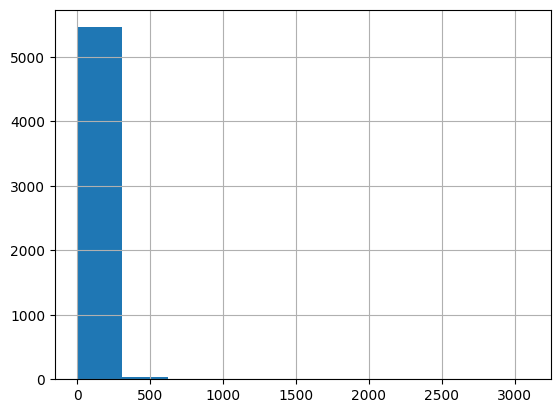

In [48]:
hist = dc['APPEARANCES'].hist()
figure = hist.get_figure()


4. Вычислим матрицу корреляции и построим heatmap для неё

Для обработки категориальных признаков воспользуемся методом Frequency Encoding, заменим значения признаков на частоту их появления в данных.



In [49]:
# создадим копию датафрейма
dc_corr = dc.copy()

In [50]:
# напомним список характеристик персонажа
display(dc_characteristics)

['ID', 'ALIGN', 'EYE', 'HAIR', 'SEX', 'ALIVE']

In [51]:
dc['EYE'].value_counts()

EYE
Unknown               2447
Blue Eyes             1068
Brown Eyes             833
Black Eyes             392
Green Eyes             264
Red Eyes               181
White Eyes             112
Yellow Eyes             73
Photocellular Eyes      40
Grey Eyes               36
Hazel Eyes              23
Purple Eyes             14
Violet Eyes             10
Gold Eyes                9
Pink Eyes                6
Orange Eyes              6
Amber Eyes               5
Name: count, dtype: int64

In [52]:
# заменим данные для каждой характеристики на частоту их появления
for i in dc_characteristics:
    dc_corr[i] = dc_corr[i].map(round(dc_corr[i].value_counts()/dc_corr[i].value_counts().sum(),2))

# проверим результат
display(dc_corr)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR,UNIVERSE
0,Batman (Bruce Wayne),0.40,0.44,0.19,0.27,0.69,0.74,3093.0,1939.0,New Earth
1,Superman (Clark Kent),0.40,0.44,0.19,0.27,0.69,0.74,2496.0,1986.0,New Earth
2,Green Lantern (Hal Jordan),0.40,0.44,0.15,0.19,0.69,0.74,1565.0,1959.0,New Earth
3,James Gordon (New Earth),0.42,0.44,0.15,0.06,0.69,0.74,1316.0,1987.0,New Earth
4,Richard Grayson (New Earth),0.40,0.44,0.19,0.27,0.69,0.74,1237.0,1940.0,New Earth
...,...,...,...,...,...,...,...,...,...,...
6523,Carnie Callahan (New Earth),0.42,0.44,0.44,0.22,0.69,0.74,1.0,1944.0,New Earth
6526,Green Arrow (Oliver Queen),0.40,0.44,0.05,0.13,0.69,0.74,1.0,1941.0,New Earth
6528,Robert Mason (New Earth),0.40,0.14,0.07,0.27,0.69,0.74,1.0,1941.0,New Earth
6529,Diablo the Horse (New Earth),0.18,0.44,0.44,0.27,0.69,0.74,1.0,1940.0,New Earth


In [53]:
# напишем функцию нормализации
def norm(x):
    min = x.min()
    max = x.max()
    result = (x - min)/ (max - min)
    return result

In [54]:
# применим функцию к столбцу APPEARANCES и YEAR и заменим значения в них
dc_corr['YEAR'] = norm(dc_corr['YEAR'])
dc_corr['APPEARANCES'] = norm(dc_corr['APPEARANCES'])

# проверим результат
display(dc_corr)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR,UNIVERSE
0,Batman (Bruce Wayne),0.40,0.44,0.19,0.27,0.69,0.74,1.000000,0.051282,New Earth
1,Superman (Clark Kent),0.40,0.44,0.19,0.27,0.69,0.74,0.806921,0.653846,New Earth
2,Green Lantern (Hal Jordan),0.40,0.44,0.15,0.19,0.69,0.74,0.505821,0.307692,New Earth
3,James Gordon (New Earth),0.42,0.44,0.15,0.06,0.69,0.74,0.425291,0.666667,New Earth
4,Richard Grayson (New Earth),0.40,0.44,0.19,0.27,0.69,0.74,0.399741,0.064103,New Earth
...,...,...,...,...,...,...,...,...,...,...
6523,Carnie Callahan (New Earth),0.42,0.44,0.44,0.22,0.69,0.74,0.000000,0.115385,New Earth
6526,Green Arrow (Oliver Queen),0.40,0.44,0.05,0.13,0.69,0.74,0.000000,0.076923,New Earth
6528,Robert Mason (New Earth),0.40,0.14,0.07,0.27,0.69,0.74,0.000000,0.076923,New Earth
6529,Diablo the Horse (New Earth),0.18,0.44,0.44,0.27,0.69,0.74,0.000000,0.064103,New Earth


In [55]:
# удалим столбы name и universe, для дальнейшей работы
dc_corr.drop(['name', 'UNIVERSE'], axis= 1 , inplace= True)

# проверим результат
display(dc_corr)

,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,0.40,0.44,0.19,0.27,0.69,0.74,1.000000,0.051282
1,0.40,0.44,0.19,0.27,0.69,0.74,0.806921,0.653846
2,0.40,0.44,0.15,0.19,0.69,0.74,0.505821,0.307692
3,0.42,0.44,0.15,0.06,0.69,0.74,0.425291,0.666667
4,0.40,0.44,0.19,0.27,0.69,0.74,0.399741,0.064103
...,...,...,...,...,...,...,...,...
6523,0.42,0.44,0.44,0.22,0.69,0.74,0.000000,0.115385
6526,0.40,0.44,0.05,0.13,0.69,0.74,0.000000,0.076923
6528,0.40,0.14,0.07,0.27,0.69,0.74,0.000000,0.076923
6529,0.18,0.44,0.44,0.27,0.69,0.74,0.000000,0.064103


In [56]:
dc_corr.corr().round(2)

,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
ID,1.00,0.01,-0.10,0.04,0.05,-0.04,0.09,-0.03
ALIGN,0.01,1.00,0.07,0.02,0.06,-0.03,0.01,-0.03
EYE,-0.10,0.07,1.00,0.03,0.09,0.01,-0.14,0.08
HAIR,0.04,0.02,0.03,1.00,0.10,0.01,-0.00,0.04
SEX,0.05,0.06,0.09,0.10,1.00,-0.09,0.02,-0.12
ALIVE,-0.04,-0.03,0.01,0.01,-0.09,1.00,0.02,0.06
APPEARANCES,0.09,0.01,-0.14,-0.00,0.02,0.02,1.00,-0.26
YEAR,-0.03,-0.03,0.08,0.04,-0.12,0.06,-0.26,1.00


In [58]:
dc_corr.corr().style.background_gradient(cmap='coolwarm')


ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [60]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data_labeled = dc.copy()
data_labeled.loc[:, 'EYE'] = labelencoder.fit_transform(data_labeled.loc[:, 'EYE'])
data_labeled.loc[:, 'HAIR'] = labelencoder.fit_transform(data_labeled.loc[:, 'HAIR'])
data_labeled


,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR,UNIVERSE
0,Batman (Bruce Wayne),Secret Identity,Good Characters,2,1,Male Characters,Living Characters,3093.0,1939.0,New Earth
1,Superman (Clark Kent),Secret Identity,Good Characters,2,1,Male Characters,Living Characters,2496.0,1986.0,New Earth
2,Green Lantern (Hal Jordan),Secret Identity,Good Characters,3,4,Male Characters,Living Characters,1565.0,1959.0,New Earth
3,James Gordon (New Earth),Public Identity,Good Characters,3,18,Male Characters,Living Characters,1316.0,1987.0,New Earth
4,Richard Grayson (New Earth),Secret Identity,Good Characters,2,1,Male Characters,Living Characters,1237.0,1940.0,New Earth
...,...,...,...,...,...,...,...,...,...,...
6523,Carnie Callahan (New Earth),Public Identity,Good Characters,13,16,Male Characters,Living Characters,1.0,1944.0,New Earth
6526,Green Arrow (Oliver Queen),Secret Identity,Good Characters,5,2,Male Characters,Living Characters,1.0,1941.0,New Earth
6528,Robert Mason (New Earth),Secret Identity,Neutral Characters,1,1,Male Characters,Living Characters,1.0,1941.0,New Earth
6529,Diablo the Horse (New Earth),Unknown,Good Characters,13,1,Male Characters,Living Characters,1.0,1940.0,New Earth


In [ ]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5519 entries, 0 to 6530
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         5519 non-null   object 
 1   ID           5519 non-null   object 
 2   ALIGN        5519 non-null   object 
 3   EYE          5519 non-null   object 
 4   HAIR         5519 non-null   object 
 5   SEX          5519 non-null   object 
 6   ALIVE        5519 non-null   object 
 7   APPEARANCES  5519 non-null   float64
 8   YEAR         5519 non-null   float64
 9   UNIVERSE     5519 non-null   object 
dtypes: float64(2), object(8)
memory usage: 474.3+ KB


6.Перевод и вывод результата

In [ ]:
# для автоматического перевода на русский язык, воспользуемся Googletrans 

import googletrans
from googletrans import Translator

In [ ]:
# генерируем список словарей для будущей замены
#translator = Translator()
#lists_translate = []

#for _ in range(len(dc_characteristics)):
        # для каждой характеристики создадим свой словарь для перевода

    #for characteristic in dc_characteristics:
        # в качестве ключей используем значения характеристик
        #dc_dict_keys = list(dc[characteristic].unique())
        #dc_dict_values = list()
        #for k in range(len(dc_dict_keys)):
          #dc_dict_values.append(translator.translate(str(dc_dict_keys[k]), dest='ru').text)
        #lists_translate.append({dc_dict_keys[i]: dc_dict_values[i] for i in range(len(dc_dict_keys))})

In [ ]:
print(lists_translate[0])

NameError: name 'lists_translate' is not defined

In [ ]:
#lists = [{} for _ in range(len(dc_characteristics))]

#lists_translate = []
#for i in range(len(dc_characteristics)):
    #lists_translate.append({})
    #lists_translate[i] = [i]
    #print(lists_translate)
    #f"dict_{i+1}" = lists_translate[i]



In [ ]:
# Преобразуем списки характеристик в более понятные предложения на русском языке

# Создадим словари для замены слов
dict_ID = {
    'Secret Identity': 'с засекреченной личностью',
    'Public Identity': 'с публичной личностью',
    'Unknown': '',
}

dict_ALIGN = {
    'Good Characters': 'добрый персонаж',
    'Bad Characters': 'злой персонаж',
    'Neutral Characters': 'нейтральный персонаж',
    'Reformed Criminals': 'персонаж встал на путь исправления',
    'Unknown': '',
}

dict_EYE = {
    'Blue Eyes': 'Голубые глаза',
    'Brown Eyes': 'Карие глаза',
    'Green Eyes': 'Зеленые глаза',
    'Purple Eyes': 'Пурпурные глаза',
    'Black Eyes': 'Черные глаза',
    'White Eyes': 'Белые глаза',
    'Red Eyes': 'Красные глаза',
    'Photocellular Eyes': 'Фотоэлементные глаза',
    'Hazel Eyes': 'Ореховые глаза',
    'Amber Eyes': 'Янтарные глаза',
    'Yellow Eyes': 'Желтые глаза',
    'Grey Eyes': 'Серые глаза',
    'Pink Eyes': 'Розовые глаза',
    'Violet Eyes': 'Фиалковые глаза',
    'Gold Eyes': 'Золотистые глаза',
    'Orange Eyes': 'Оранжевые глаза',
    'Unknown': '', ''
}

dict_ALIGN = {
    'Good Characters': 'добрый персонаж',
    'Bad Characters': 'злой персонаж',
    'Neutral Characters': 'нейтральный персонаж',
    'Reformed Criminals': 'персонаж встал на путь исправления',
    'Unknown': '',
}
# Создадим функцию для замены слов

def eng_to_rus(word):

Column: EYE
Unique Values: ['Blue Eyes' 'Brown Eyes' 'Green Eyes' 'Purple Eyes' 'Black Eyes'
 'White Eyes' 'Red Eyes' 'Photocellular Eyes' 'Hazel Eyes' 'Amber Eyes'
 'Yellow Eyes' nan 'Grey Eyes' 'Pink Eyes' 'Violet Eyes' 'Gold Eyes'
 'Orange Eyes' 'Auburn Hair']

Column: HAIR
Unique Values: ['Black Hair' 'Brown Hair' 'White Hair' 'Blond Hair' 'Red Hair' nan
 'Green Hair' 'Strawberry Blond Hair' 'Grey Hair' 'Silver Hair'
 'Orange Hair' 'Purple Hair' 'Gold Hair' 'Blue Hair' 'Reddish Brown Hair'
 'Pink Hair' 'Violet Hair' 'Platinum Blond Hair']

Column: SEX
Unique Values: ['Male Characters' 'Female Characters' nan 'Genderless Characters'
 'Transgender Characters']

Column: ALIVE
Unique Values: ['Living Characters' 'Deceased Characters' nan]


SyntaxError: invalid syntax (964805114.py, line 36)

In [ ]:
dc_HAIR = dc.groupby('HAIR')['APPEARANCES'].max().sort_values(ascending=False)
dc_HAIR.head()

HAIR
Black Hair    3093.0
Brown Hair    1565.0
White Hair    1316.0
Blond Hair    1121.0
Red Hair       951.0
Name: APPEARANCES, dtype: float64

In [ ]:
dc.groupby(['ID', 'ALIGN', 'EYE', 'HAIR', 'SEX', 'ALIVE'])['APPEARANCES'].max().unstack().head()

ALIVE                                                                    Deceased Characters  \
ID              ALIGN          EYE         HAIR       SEX                                      
Public Identity Bad Characters Auburn Hair Unknown    Female Characters                  NaN   
                               Black Eyes  Black Hair Female Characters                 25.0   
                                                      Male Characters                  142.0   
                                                      Unknown                            1.0   
                                           Blond Hair Male Characters                    6.0   

ALIVE                                                                    Living Characters  \
ID              ALIGN          EYE         HAIR       SEX                                    
Public Identity Bad Characters Auburn Hair Unknown    Female Characters                5.0   
                               Black Eyes  Black Hair Female Characters               61.0   
                                                      Male Characters                158.0   
                                                      Unknown                          NaN   
                                           Blond Hair Male Characters                  3.0   

ALIVE                                                                    Unknown  
ID              ALIGN          EYE         HAIR       SEX                         
Public Identity Bad Characters Auburn Hair Unknown    Female Characters      NaN  
                               Black Eyes  Black Hair Female Characters      NaN  
                                                      Male Characters        NaN  
                                                      Unknown                NaN  
                                           Blond Hair Male Characters        NaN

In [ ]:
dc.pivot_table(
    values='APPEARANCES',
    index=['ID', 'ALIGN', 'EYE', 'HAIR', 'SEX', 'ALIVE'],
    columns='Regionname',
    aggfunc='max',
    fill_value=0
)

In [ ]:
display(dc)

,name,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,YEAR
0,Batman (Bruce Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,3093.0,1939.0
1,Superman (Clark Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,2496.0,1986.0
2,Green Lantern (Hal Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,Living Characters,1565.0,1959.0
3,James Gordon (New Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,Living Characters,1316.0,1987.0
4,Richard Grayson (New Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,1237.0,1940.0
...,...,...,...,...,...,...,...,...,...
6527,Gypper Zilich (New Earth),Unknown,Unknown,Unknown,Black Hair,Male Characters,Living Characters,1.0,1941.0
6528,Robert Mason (New Earth),Secret Identity,Neutral Characters,Black Eyes,Black Hair,Male Characters,Living Characters,1.0,1941.0
6529,Diablo the Horse (New Earth),Unknown,Good Characters,Unknown,Black Hair,Male Characters,Living Characters,1.0,1940.0
6530,Scott Scanlon (New Earth),Public Identity,Unknown,Unknown,Blond Hair,Male Characters,Living Characters,1.0,1938.0
